# OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction

This project is from this [Kaggle competition](https://www.kaggle.com/c/stanford-covid-vaccine). A brief summary is given below (from the competition itself).

mRNA vaccines have taken the lead as the fastest vaccine candidates for COVID-19, but currently, they face key potential limitations. One of the biggest challenges right now is how to design super stable messenger RNA molecules (mRNA). Conventional vaccines (like your seasonal flu shots) are packaged in disposable syringes and shipped under refrigeration around the world, but that is not currently possible for mRNA vaccines.

Researchers have observed that RNA molecules have the tendency to spontaneously degrade. This is a serious limitation--a single cut can render the mRNA vaccine useless. Currently, little is known on the details of where in the backbone of a given RNA is most prone to being affected. Without this knowledge, current mRNA vaccines against COVID-19 must be prepared and shipped under intense refrigeration, and are unlikely to reach more than a tiny fraction of human beings on the planet unless they can be stabilized.

In this competition, the goal is to develop a models which predicts likely degradation rates at each base of an RNA molecule. We are given a subset of an Eterna dataset comprising over 3000 RNA molecules (which span a panoply of sequences and structures) and their degradation rates at each position. The model is scored on a second generation of RNA sequences that have just been devised by Eterna players for COVID-19 mRNA vaccines.

This kernel was mainly used for learning purpose. The models are inspired from those of the Kaggle community. In particular, RNN-based (LSTM & GRU) models and embeddings are used.

At the end of the competition, the best model is the one presented in this notebook: 0.42265 private LB (top 61%), 0.25281 public LB. It didn't perform very well but it was great learning material. It is also interesting to note that downscaling the final results will yied a higher score (see https://www.kaggle.com/c/stanford-covid-vaccine/discussion/189182 for more information).

References:
- https://www.kaggle.com/its7171/gru-lstm-with-feature-engineering-and-augmentation
- https://www.kaggle.com/xhlulu/openvaccine-simple-gru-model
- https://www.kaggle.com/tuckerarrants/openvaccine-gru-lstm

## Libraries

In [ ]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline

from IPython.display import clear_output, display

from sklearn.model_selection import KFold, train_test_split

import tensorflow as tf
from tensorflow.keras import layers
clear_output()

## Data Loading & Inspection

In [ ]:
train = pd.read_json('../input/stanford-covid-vaccine/train.json', lines=True)
test = pd.read_json('../input/stanford-covid-vaccine/test.json', lines=True)

train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [ ]:
test.head()

,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [ ]:
print(f'Train / test set size: {train.shape} / {test.shape}')

Train / test set size: (2400, 19) / (3634, 7)


Let's see how many samples with "good" `signal_to_noise` (>1) we have as well as how many passed the filter used for the test set (`SN_filter`).

In [ ]:
print(f"Samples with signal_to_noise >= 1: {train[train['signal_to_noise'] >= 1].shape[0]} / {train.shape[0]}")
print(f"Samples with SN_filter = 1: {train[train['SN_filter'] >= 1].shape[0]} / {train.shape[0]}")

Samples with signal_to_noise >= 1: 2097 / 2400
Samples with SN_filter = 1: 1589 / 2400


## Feature Engineering

Reuse code from this [Kaggle kernel](https://www.kaggle.com/its7171/gru-lstm-with-feature-engineering-and-augmentation).

In [ ]:
def read_bpps_sum(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy").sum(axis=1))
    return bpps_arr

def read_bpps_max(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy").max(axis=1))
    return bpps_arr

def read_bpps_nb(df):
    #mean and std from https://www.kaggle.com/symyksr/openvaccine-deepergcn 
    bpps_nb_mean = 0.077522
    bpps_nb_std = 0.08914
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps = np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy")
        bpps_nb = (bpps > 0).sum(axis=0) / bpps.shape[0]
        bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
        bpps_arr.append(bpps_nb)
    return bpps_arr 

train['bpps_sum'] = read_bpps_sum(train)
test['bpps_sum'] = read_bpps_sum(test)
train['bpps_max'] = read_bpps_max(train)
test['bpps_max'] = read_bpps_max(test)
train['bpps_nb'] = read_bpps_nb(train)
test['bpps_nb'] = read_bpps_nb(test)

#sanity check
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,...,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,bpps_sum,bpps_max,bpps_nb
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...",...,"[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000...","[0.19854229, 0.18371220000000002, 0.0600024000...","[0.0217857, 0.0386527, 0.0275904, 0.00947066, ...","[2.0659663786252436, 1.2272143577570933, -0.34..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...",...,"[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.16883627604054915, 0.10675940059456464, 0.0...","[0.11931483477784201, 0.0808186531761711, 0.06...","[0.49330633949746183, 0.49330633949746183, -0...."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...",...,"[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499...","[0.06680724164624499, 0.04433748694733778, 0.0...","[0.017340043515196805, 0.00826566577930985, 0....","[2.275654383842281, 2.5901863916678374, 0.8078..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...",...,"[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.22702912000000003, 0.18439387000000002, 0.0...","[0.0350158, 0.0332295, 0.00272567, 0.0, 0.0, 0...","[0.5981503421059805, 0.9126823499315369, -0.65..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...",...,"[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,...","[0.04036075455181073, 0.08021642791992274, 0.0...","[0.02230060114516417, 0.052274223411953764, 0....","[0.5981503421059805, 0.807838347323

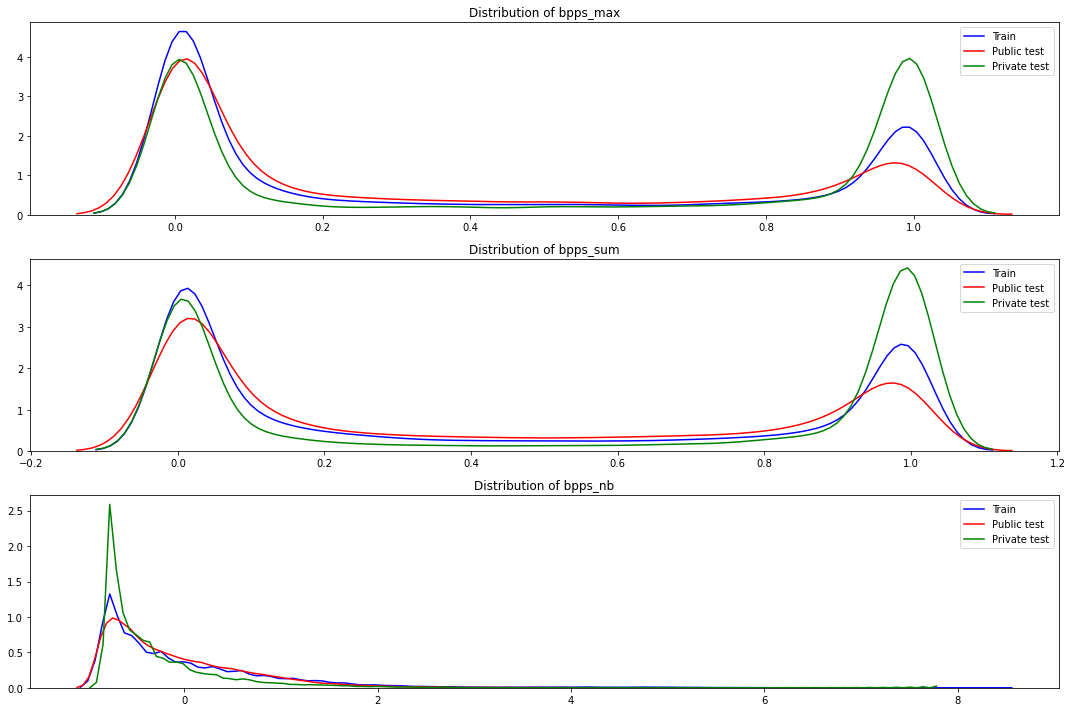

In [ ]:
fig, ax = plt.subplots(3, figsize=(15, 10))
sns.kdeplot(np.array(train['bpps_max'].to_list()).reshape(-1),
            color="Blue", ax=ax[0], label='Train')
sns.kdeplot(np.array(test[test['seq_length'] == 107]['bpps_max'].to_list()).reshape(-1),
            color="Red", ax=ax[0], label='Public test')
sns.kdeplot(np.array(test[test['seq_length'] == 130]['bpps_max'].to_list()).reshape(-1),
            color="Green", ax=ax[0], label='Private test')
sns.kdeplot(np.array(train['bpps_sum'].to_list()).reshape(-1),
            color="Blue", ax=ax[1], label='Train')
sns.kdeplot(np.array(test[test['seq_length'] == 107]['bpps_sum'].to_list()).reshape(-1),
            color="Red", ax=ax[1], label='Public test')
sns.kdeplot(np.array(test[test['seq_length'] == 130]['bpps_sum'].to_list()).reshape(-1),
            color="Green", ax=ax[1], label='Private test')
sns.kdeplot(np.array(train['bpps_nb'].to_list()).reshape(-1),
            color="Blue", ax=ax[2], label='Train')
sns.kdeplot(np.array(test[test['seq_length'] == 107]['bpps_nb'].to_list()).reshape(-1),
            color="Red", ax=ax[2], label='Public test')
sns.kdeplot(np.array(test[test['seq_length'] == 130]['bpps_nb'].to_list()).reshape(-1),
            color="Green", ax=ax[2], label='Private test')

ax[0].set_title('Distribution of bpps_max')
ax[1].set_title('Distribution of bpps_sum')
ax[2].set_title('Distribution of bpps_nb')
plt.legend()
plt.tight_layout();

## Data Augmentation

Augmented data is generated with this [Kaggle kernel](https://www.kaggle.com/its7171/how-to-generate-augmentation-data).

In [ ]:
aug_df = pd.read_csv('../input/openvaccine-augmented-data/aug_data.csv')
print(aug_df.shape)
aug_df.head()

(6034, 7)


,id,sequence,structure,log_gamma,score,cnt,predicted_loop_type
0,id_ffda94f24,GGAAAAACCAAUUGCUAUUAAAGGUUCCUUUGUUCGCUAAGUCCAA...,.......(((..((((..(.(((((.(((((((...((..(((((....,1,0.861356,4,EEEEEEESSSIISSSSBBSBSSSSSBSSSSSSSIIISSIISSSSSH...
1,id_0d893f433,GGAAAUUGGCCAUCGUAACGGCGUGUGCAGGAGCUACGAACCUCUG...,................(((.(((((.((..((((.....(((((.(...,0,0.856460,5,EEEEEEEEEEEEEEEESSSISSSSSBSSIISSSSBBBBBSSSSSBS...
2,id_0d9d2e775,GGAAACAACACGAGAACAGUGAUGACACAAGUACCUACGGUUACGU...,.....(((((((((..((((((((.(.((((((((((((....)))...,0,0.993848,4,EEEEESSSSSSSSSIISSSSSSSSBSBSSSSSSSSSSSSHHHHSSS...
3,id_0da46ead4,GGAAACGCCGCCGGCCGGCCUGCCAGCAGCGCGGUAUGCCUGCAUA...,(....)..((((((.(((.(((...(..(((((.((((....))))...,2,0.897231,3,SHHHHSXXSSSSSSISSSISSSMMMSBBSSSSSISSSSHHHHSSSS...
4,id_0da624e95,GGAAACGUCCGCGAUCUUUGCCAACCCGCAACUCUACAUGAUCGGA...,(((....)))....(((((((......)))(((((...(((..(((...,1,0.862958,5,SSSHHHHSSSXXXXSSSSSSSHHHHHHSSSSSSSSBBBSSSBBSSS...


In [ ]:
def aug_data(df):
    target_df = df.copy()
    new_df = aug_df[aug_df['id'].isin(target_df['id'])]
                         
    del target_df['structure']
    del target_df['predicted_loop_type']
    new_df = new_df.merge(target_df, on=['id','sequence'], how='left')

    df['cnt'] = df['id'].map(new_df[['id','cnt']].set_index('id').to_dict()['cnt'])
    df['log_gamma'] = 100
    df['score'] = 1.0
    df = df.append(new_df[df.columns])
    return df

In [ ]:
print(f"Samples in train before augmentation: {len(train)}")
print(f"Samples in test before augmentation: {len(test)}")

train = aug_data(train)
test = aug_data(test)

print(f"Samples in train after augmentation: {len(train)}")
print(f"Samples in test after augmentation: {len(test)}")

print(f"Unique sequences in train: {len(train['sequence'].unique())}")
print(f"Unique sequences in test: {len(test['sequence'].unique())}")

Samples in train before augmentation: 2400
Samples in test before augmentation: 3634
Samples in train after augmentation: 4800
Samples in test after augmentation: 7268
Unique sequences in train: 2400
Unique sequences in test: 3634


## Data Processing

In [ ]:
def preprocess(df, token2int, token_cols, extra_cols=None):
    res = [[[token2int[x] for x in seq] for seq in df[col]] for col in token_cols]
    res = np.moveaxis(np.array(res), 0, -1)
    if extra_cols is not None:
        extra = [np.array(df[col].to_list())[:, :, np.newaxis] for col in extra_cols]
        return np.concatenate([res] + extra, 2)
    else:
        return res

token2int = {x: i for i, x in enumerate('().ACGUBEHIMSX')}

in_cols = ['sequence', 'structure', 'predicted_loop_type']
extra_cols = ['bpps_sum', 'bpps_max']
train_seq = preprocess(train, token2int, in_cols, extra_cols) # (2400, 107, 3) = (samples, seq_len, channels)

label_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C']
labels = np.moveaxis(np.array(train[label_cols].to_numpy().tolist()), 1, -1) # (2400, 68, 5)

In [ ]:
public_df = test[test['seq_length'] == 107]
private_df = test[test['seq_length'] == 130]

public = preprocess(public_df, token2int, in_cols, extra_cols)
private = preprocess(private_df, token2int, in_cols, extra_cols)

## Model - LSTM & GRU

RNN architecture is inspired from https://www.kaggle.com/xhlulu/openvaccine-simple-gru-model and https://www.kaggle.com/tuckerarrants/openvaccine-gru-lstm. Embeddings are used to encode the input sequences. Various variations have also been tested.

In [ ]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

def RNN(rnn_type, hidden_dim, dropout=0.0, regularize=0.0):
    if rnn_type == 'lstm':
        RNNLayer = layers.LSTM
    elif rnn_type == 'gru':
        RNNLayer = layers.GRU

    if regularize > 0:
        regularizer = tf.keras.regularizers.l2(regularize)
    else:
        regularizer = None

    rnn = RNNLayer(hidden_dim, kernel_regularizer=regularizer, recurrent_regularizer=regularizer, dropout=dropout,
                   return_sequences=True)
    return layers.Bidirectional(rnn)

def create_model(seq_len, embed_size, embed_dim, rnn, hidden_dim, dropout=0.5, pred_len=68):
    inputs = layers.Input(shape=(seq_len, 5))
    categoricals = inputs[:, :, :3]
    numericals = inputs[:, :, 3:]
    embed = layers.Embedding(input_dim=embed_size, output_dim=embed_dim)(categoricals)
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3])
    )
    reshaped = tf.keras.layers.concatenate([reshaped, numericals], axis=2)
    # hidden = layers.Conv1D(256, 3, padding='same', activation='relu')(reshaped)
    # hidden = layers.Conv1D(128, 3, padding='same', activation='relu')(hidden)
    # hidden = layers.Conv1D(64, 3, padding='same', activation='relu')(hidden)
    # hidden = layers.Conv1D(128, 3, padding='same', activation='relu')(hidden)
    # hidden = layers.Conv1D(256, 3, padding='same', activation='relu')(hidden)
    # hidden = layers.Conv1D(602, 3, padding='same')(hidden)
    # reshaped = tf.keras.layers.average([reshaped, hidden])
    hidden = layers.SpatialDropout1D(0.2)(reshaped)
    hidden = RNN(rnn, hidden_dim, regularize=0.0)(hidden)
#     for _ in range(1, 3):
#         hidden = RNN(rnn, hidden_dim, dropout=dropout, regularize=0.0)(hidden)
    hidden = RNN(rnn, hidden_dim, dropout=dropout, regularize=0.0)(hidden)
    hidden = RNN(rnn, hidden_dim, dropout=dropout, regularize=0.0)(hidden)
    # hidden = layers.Conv1D(200, 3, padding='valid')(hidden)
    truncated = hidden[:, :pred_len]
    # x = layers.Dropout(0.2)(truncated)
    x = layers.Dense(256, activation='relu')(truncated)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(5, activation='linear')(x)

    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9), loss=MCRMSE, metrics=[MCRMSE])

    return model

In [ ]:
embed_size = len(token2int)
embed_dim = 200
hidden_dim = 256

model = create_model(train_seq.shape[1], embed_size, embed_dim, 'lstm', hidden_dim)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 107, 5)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 107, 3)]     0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 107, 3, 200)  2800        tf_op_layer_strided_slice[0][0]  
__________________________________________________________________________________________________
tf_op_layer_Reshape (TensorFlow [(None, 107, 600)]   0           embedding[0][0]                  
_______________________________________________________________________________________

In [ ]:
model = create_model(train_seq.shape[1], embed_size, embed_dim, 'gru', hidden_dim)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 107, 5)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_3 (Te [(None, 107, 3)]     0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 107, 3, 200)  2800        tf_op_layer_strided_slice_3[0][0]
__________________________________________________________________________________________________
tf_op_layer_Reshape_1 (TensorFl [(None, 107, 600)]   0           embedding_1[0][0]                
_______________________________________________________________________________________

## Training & Prediction

Each model is trained using k-fold CV and the final predictions are the average of all folds and all model types (LSTM & GRU). Only the samples with `SN_filter = 1` are used for validation.

In [ ]:
def format_preds(public_df, preds_public, private_df, preds_private):
    preds_ls = []

    for df, preds in [(public_df, preds_public), (private_df, preds_private)]:
        for i, uid in enumerate(df.id):
            single_pred = preds[i]

            single_df = pd.DataFrame(single_pred, columns=label_cols)
            single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

            preds_ls.append(single_df)

    preds_df = pd.concat(preds_ls).groupby('id_seqpos').mean().reset_index()
    return preds_df

In [ ]:
batch_size = 64
epochs = 100

folds = 5
kf = KFold(n_splits=folds, shuffle=True)

idx_pool = train.index[train['SN_filter'] == 1]

histories = [[], []]
preds = [[], []]

for train_idx, val_idx in kf.split(train_seq):
    mask_val = train.index.isin(idx_pool[idx_pool.isin(val_idx)])
    X_train, y_train = train_seq[~mask_val], labels[~mask_val]
    X_val, y_val = train_seq[mask_val], labels[mask_val]

    epsilon = .1
    sample_weight = np.log1p(train.loc[~mask_val, 'signal_to_noise'] + epsilon) / 2

    for i, rnn in enumerate(['lstm', 'gru']):
        callbacks = [
            tf.keras.callbacks.ReduceLROnPlateau(patience=10, verbose=1, min_lr=1e-5),
            tf.keras.callbacks.EarlyStopping(patience=50, verbose=1),
            tf.keras.callbacks.ModelCheckpoint(f'{rnn}_best_model.h5', monitor='val_MCRMSE', mode='min', verbose=1,
                                               save_best_only=True),
            tf.keras.callbacks.ModelCheckpoint(f'{rnn}_model.h5', monitor='val_MCRMSE', mode='min'),
        ]

        model = create_model(train_seq.shape[1], embed_size, embed_dim, rnn, hidden_dim)
        histories[i].append(model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size,
                                   epochs=epochs, callbacks=callbacks, sample_weight=sample_weight))
        print()

        model_public = create_model(public.shape[1], embed_size, embed_dim, rnn, hidden_dim, pred_len=public.shape[1])
        model_public.load_weights(f'{rnn}_best_model.h5')
        preds_public = model_public.predict(public)

        model_private = create_model(private.shape[1], embed_size, embed_dim, rnn, hidden_dim, pred_len=private.shape[1])
        model_private.load_weights(f'{rnn}_best_model.h5')
        preds_private = model_private.predict(private)

        preds[i].append([preds_public, preds_private])

    print('\n' + '#' * 20 + '\n')

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.3503 - MCRMSE: 0.5939
Epoch 00001: val_MCRMSE improved from inf to 0.50494, saving model to lstm_best_model.h5
62/62 [==============================] - 9s 147ms/step - loss: 0.3503 - MCRMSE: 0.5939 - val_loss: 0.5049 - val_MCRMSE: 0.5049
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.2908 - MCRMSE: 0.5232
Epoch 00002: val_MCRMSE improved from 0.50494 to 0.46976, saving model to lstm_best_model.h5
62/62 [==============================] - 7s 117ms/step - loss: 0.2908 - MCRMSE: 0.5232 - val_loss: 0.4698 - val_MCRMSE: 0.4698
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.2711 - MCRMSE: 0.4998
Epoch 00003: val_MCRMSE improved from 0.46976 to 0.45160, saving model to lstm_best_model.h5
62/62 [==============================] - 7s 115ms/step - loss: 0.2711 - MCRMSE: 0.4998 - val_loss: 0.4516 - val_MCRMSE: 0.4516
Epoch 4/100
62/62 [==============================] - ETA: 0s - lo

LSTM - train: [0.11041634529829025, 0.11096783727407455, 0.11117511987686157, 0.11080070585012436, 0.11029805988073349] (0.11073161363601684)
       val: [0.29381871223449707, 0.2608284652233124, 0.24617531895637512, 0.2760351598262787, 0.27003908157348633] (0.2693793475627899)
GRU - train: [0.12366712838411331, 0.12379799038171768, 0.12344439327716827, 0.12355205416679382, 0.12302345037460327] (0.12349700331687927)
      val: [0.30329036712646484, 0.2710029184818268, 0.25605258345603943, 0.28660479187965393, 0.28014758229255676] (0.27941964864730834)


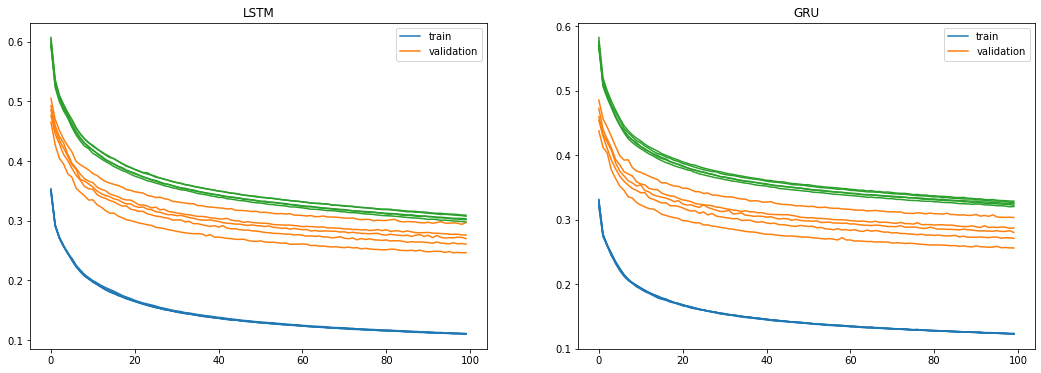

In [ ]:
# Plot training history
fix, ax = plt.subplots(1, 2, figsize=(18, 6))

best = []

for i, rnn_histories in enumerate(histories):
    best.append([[], []])
    for history in rnn_histories:
        ax[i].plot(history.history['loss'], color='C0')
        ax[i].plot(history.history['val_MCRMSE'], color='C1')
        ax[i].plot(history.history['MCRMSE'], color='C2')
        ax[i].legend(['train', 'validation'])
        if i == 0:
            ax[i].set_title('LSTM')
        elif i == 1:
            ax[i].set_title('GRU')

        idx = np.argmin(history.history['val_MCRMSE'])
        best[i][0].append(history.history['loss'][idx])
        best[i][1].append(history.history['val_MCRMSE'][idx])

print(f"LSTM - train: {best[0][0]} ({np.mean(best[0][0])})")
print(f"       val: {best[0][1]} ({np.mean(best[0][1])})")
print(f"GRU - train: {best[1][0]} ({np.mean(best[1][0])})")
print(f"      val: {best[1][1]} ({np.mean(best[1][1])})")

In [ ]:
preds_one = [] # LSTM, GRU

for i, rnn_preds in enumerate(preds):
    for j, p in enumerate(rnn_preds):
        preds_public, preds_private = p[0], p[1]
        tmp = format_preds(public_df, preds_public, private_df, preds_private)

        if j == 0:
            preds_one.append(tmp)
        else:
            preds_one[i][label_cols] += tmp[label_cols]

    preds_one[i][label_cols] /= folds

preds_df = pd.DataFrame()
preds_df['id_seqpos'] = preds_one[0]['id_seqpos']
preds_df[label_cols] = sum([x[label_cols] for x in preds_one]) / len(preds_one)
print(preds_df.shape)
preds_df.head()

(457953, 6)


,id_seqpos,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C
0,id_00073f8be_0,0.753202,0.639893,0.518063,2.123222,0.769860
1,id_00073f8be_1,2.159471,3.080553,2.950203,3.702610,2.680153
2,id_00073f8be_10,0.372192,0.483556,0.436630,0.502839,0.822712
3,id_00073f8be_100,0.215936,0.419559,0.510772,0.678086,0.659878
4,id_00073f8be_101,0.404155,0.234420,0.286184,0.381880,0.534611


In [ ]:
sample_df = pd.read_csv('../input/stanford-covid-vaccine/sample_submission.csv')
submission = sample_df[['id_seqpos']].merge(preds_df, on=['id_seqpos'])
submission.to_csv('submission.csv', index=False)
submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C
0,id_00073f8be_0,0.753202,0.639893,0.518063,2.123222,0.769860
1,id_00073f8be_1,2.159471,3.080553,2.950203,3.702610,2.680153
2,id_00073f8be_2,1.539612,0.634696,0.711728,0.669124,0.695061
3,id_00073f8be_3,1.298639,1.117999,1.560861,1.156703,1.881267
4,id_00073f8be_4,0.828052,0.573195,0.830224,0.511231,0.895030
